# Activity: Build an XGBoost model

## Introduction

In this activity, you’ll build on the skills and techniques you learned in the decision tree and random forest lessons to construct your own XGBoost classification model. The XGBoost model is a very powerful extension of decision trees, so having a strong working familiarity with this process will strengthen your skills and resume as a data professional.

This activity is a continuation of the airlines project in which you built decision tree and random forest models. You will use the same data, but this time you will train, tune, and evaluate an XGBoost model. You’ll then compare the performance of all three models and decide which model is best. Finally, you’ll explore the feature importances of your model and identify the features that most contribute to customer satisfaction.


## Step 1: Imports

### Import packages

Begin with your import statements. First, import `pandas`, `numpy`, and `matplotlib` for data preparation. Next, import scikit-learn (`sklearn`) for model preparation and evaluation. Then, import `xgboost`, which provides the classification algorithm you'll implement to formulate your predictive model.

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, confusion_matrix

from xgboost import XGBClassifier, plot_importance
import pickle

path = "D:/Pulkit/2017 Class-XII/Google Advanced Data Analytics Professional Certificate/5 - Regression Analysis/Datasets/"

### Load the dataset

To formulate your model, `pandas` is used to import a csv of airline passenger satisfaction data called `Invistico_Airline.csv`. This DataFrame is called `airline_data`. As shown in this cell, the dataset has been automatically loaded in for you. You do not need to download the .csv file, or provide more code, in order to access the dataset and proceed with this lab. Please continue with this activity by completing the following instructions.

In [2]:
# RUN THIS CELL TO IMPORT YOUR DATA.
df0 = pd.read_csv(path + 'airline_train.csv')
df0.head()

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


### Display the data type for each column

Next, observe the types of data present within this dataset.

In [3]:
df = df0.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103904 entries, 0 to 103903
Data columns (total 25 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Unnamed: 0                         103904 non-null  int64  
 1   id                                 103904 non-null  int64  
 2   Gender                             103904 non-null  object 
 3   Customer Type                      103904 non-null  object 
 4   Age                                103904 non-null  int64  
 5   Type of Travel                     103904 non-null  object 
 6   Class                              103904 non-null  object 
 7   Flight Distance                    103904 non-null  int64  
 8   Inflight wifi service              103904 non-null  int64  
 9   Departure/Arrival time convenient  103904 non-null  int64  
 10  Ease of Online booking             103904 non-null  int64  
 11  Gate location                      1039

<details>
<summary><h4><strong>Hint 1</strong></h4></summary>

Recall the methods for exploring DataFrames.
</details>

<details>
<summary><h4><strong>Hint 2</strong></h4></summary>

Recall a property of a `pandas` DataFrame that allows you to view the data type for each column.</details>

<details>
<summary><h4><strong>Hint 3</strong></h4></summary>

Call `.dtypes` on your DataFrame `airline_data` to view the data type of each column.</details>

**Question:** Identify the target (or predicted) variable for passenger satisfaction. What is your initial hypothesis about which variables will be valuable in predicting satisfaction?

satisfaction column is the target column.

Seat comfort, Inflight entertainment, On-board service, Leg room service will be valuable in predicting satisfaction.

## Step 2: Model preparation

Before you proceed with modeling, consider which metrics you will ultimately want to leverage to evaluate your model.

**Question:** Which metrics are most suited to evaluating this type of model?

f1, accuracy

### Prepare your data for predictions

You may have noticed when previewing your data that there are several non-numerical variables (`object` data types) within the dataset.


In [4]:
# Drop missing values.
# Save the DataFrame in variable `air_data_subset`.
air_df = df.dropna().reset_index(drop=True)

In [7]:
le = LabelEncoder().fit(air_df.Class)
air_df.Class = le.transform(air_df.Class)

air_df.satisfaction = air_df.satisfaction.map({'satisfied': 1, 'neutral or dissatisfied': 0})
air_df['IsLoyal'] = air_df['Customer Type'].map({'Loyal Customer': 1, 'disloyal Customer': 0})
air_df['IsPersonalTravel'] = air_df['Type of Travel'].map({'Personal Travel': 1, 'Business travel': 0})

air_df.drop(columns=['Unnamed: 0', 'id', 'Type of Travel', 'Customer Type', 'Gender'], inplace=True)

In [8]:
# Display the first 5 rows.
air_df.head()

,Age,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,...,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction,IsLoyal,IsPersonalTravel
0,13,2,460,3,4,3,1,5,3,5,...,3,4,4,5,5,25,18.0,0,1,1
1,25,0,235,3,2,3,3,1,3,1,...,5,3,1,4,1,1,6.0,0,0,0
2,26,0,1142,2,2,2,2,5,5,5,...,3,4,4,4,5,0,0.0,1,1,0
3,25,0,562,2,5,5,5,2,2,2,...,5,3,1,4,2,11,9.0,0,1,0
4,61,0,214,3,3,3,3,4,5,5,...,4,4,3,3,3,0,0.0,1,1,0


<details>
<summary><h4><strong>Hint 1</strong></h4></summary>

Refer to [the content about feature engineering](https://www.coursera.org/learn/the-nuts-and-bolts-of-machine-learning/lecture/5mEqu/introduction-to-feature-engineering).
</details>

<details>
<summary><h4><strong>Hint 2</strong></h4></summary>

Use the `pandas` function for transforming categorical data into "dummy" variables.</details>

<details>
<summary><h4><strong>Hint 3</strong></h4></summary>

Use the `get_dummies()` function on your DataFrame `airline_data` to create dummies for the categorical variables in your dataset. Note that your target variable will also need this treatment.</details>

### Isolate your target and predictor variables
Separately define the target variable (`satisfaction`) and the features.

In [9]:
# Separate the dataset into labels (y) and features (X).
X = air_df.drop(columns=['satisfaction'])
y = air_df.satisfaction

<details>
<summary><h4><strong>Hint 1</strong></h4></summary>

Refer to [the content about splitting your data into x and y](https://www.coursera.org/learn/the-nuts-and-bolts-of-machine-learning/lecture/ozK9K/build-a-decision-tree-with-python).
</details>

<details>
<summary><h4><strong>Hint 2</strong></h4></summary>

In `pandas`, use square brackets `[]` to subset your DataFrame by specifying which column(s) to select. Also, quickly subset a DataFrame to exclude a particular column by using the `drop()` function and specifying the column to drop.
</details>

<details>
<summary><h4><strong>Hint 3</strong></h4></summary>

In this case, your target variable was split into two columns from the dummy split. Be sure to include only the column which assigns a positive (i.e., "satisfied") outcome as 1.
</details>

### Divide your data 

Divide your data into a training set (75% of the data) and test set (25% of the data). This is an important step in the process, as it allows you to reserve a part of the data that the model has not used to test how well the model generalizes (or performs) on new data.

In [10]:
# Separate into train, validate, test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=43)
#X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.25, stratify=y_train, random_state=43)

<details>
<summary><h4><strong>Hint 1</strong></h4></summary>

Refer to [the content about splitting your data between a training and test set](https://www.coursera.org/learn/the-nuts-and-bolts-of-machine-learning/lecture/ozK9K/build-a-decision-tree-with-python).
</details>

<details>
<summary><h4><strong>Hint 2</strong></h4></summary>

To perform the splitting, call the function in the `model_selection` module of `sklearn` on the features and target variable.
</details>

<details>
<summary><h4><strong>Hint 3</strong></h4></summary>

Call the `train_test_split()` function, passing in both `features` and `target`, while configuring the appropriate `test_size`. Assign the output of this split as `X_train`, `X_test`, `y_train`, `y_test`.
</details>

## Step 3: Model building

### "Instantiate" your XGBClassifer

Before you fit your model to your airline dataset, first create the XGB Classifier model and define its objective. You'll use this model to fit and score different hyperparameters during the GridSearch cross-validation process.

In [11]:
# Define xgb to be your XGBClassifier.
xgb = XGBClassifier(objective='binary:logistic',random_state=0)

<details>
<summary><h4><strong>Hint 1</strong></h4></summary>

Refer to [the content about constructing a classifier model from `xgboost`](https://www.coursera.org/learn/the-nuts-and-bolts-of-machine-learning/lecture/njRAP/build-an-xgboost-model-with-python).</details>

<details>
<summary><h4><strong>Hint 2</strong></h4></summary>

Note that the target variable in this case is a binary variable. </details>

<details>
<summary><h4><strong>Hint 3</strong></h4></summary>

Use the `XGBClassifier()` from `xgboost`. Set the objective as `binary:logistic`.
</details>

### Define the parameters for hyperparameter tuning

To identify suitable parameters for your `xgboost` model, first define the parameters for hyperparameter tuning. Specifically, define a range of values for `max_depth`, `min_child_weight`, `learning_rate`, `n_estimators`, `subsample`, and `colsample_bytree`.

Consider a more limited range for each parameter to allow for timely iteration and model training.

In [12]:
# Define parameters for tuning as `cv_params`.

cv_params = {'max_depth': [4, 6],
             'min_child_weight': [3, 5],
             'learning_rate': [0.1, 0.2, 0.3],
             'n_estimators': [5,10,15],
             'subsample': [0.7],
             'colsample_bytree': [0.7]
             }

<details>
<summary><h4><strong>Hint 1</strong></h4></summary>

Refer to [the content about hyperparameter tuning using GridSearch cross-validation](https://www.coursera.org/learn/the-nuts-and-bolts-of-machine-learning/lecture/afopk/tune-a-decision-tree).</details>

<details>
<summary><h4><strong>Hint 2</strong></h4></summary>

Consider a range of values for each parameter, similar to what you observed in the lesson. </details>

<details>
<summary><h4><strong>Hint 3</strong></h4></summary>

Define these parameters using a Python dictionary in the following format: `{'parameter1': [range,of,values]}`</details>

**Question:** What is the likely effect of adding more estimators to your GridSearch?

Increase in tuning time 

### Define how the models will be evaluated

Define how the models will be evaluated for hyperparameter tuning. To yield the best understanding of model performance, utilize a suite of metrics.

In [13]:
# Define your criteria as `scoring`.
scoring = {'accuracy', 'precision', 'recall', 'f1'}

<details>
<summary><h4><strong>Hint 1</strong></h4></summary>

Recall what you've learned about [using metric evaluation](https://www.coursera.org/learn/the-nuts-and-bolts-of-machine-learning/lecture/afopk/tune-a-decision-tree) to determine the metrics you include.</details>

<details>
<summary><h4><strong>Hint 2</strong></h4></summary>

Consider what you've learned about the limitations of only including a single metric, such as `accuracy`. </details>

<details>
<summary><h4><strong>Hint 3</strong></h4></summary>

Define metrics which balance the false positives and false negatives in binary classification problems.

### Construct the GridSearch cross-validation 

Construct the GridSearch cross-validation using the model, parameters, and scoring metrics you defined. Additionally, define the number of folds and specify *which metric* from above will guide the refit strategy.

In [14]:
# Construct your GridSearch.
xgb_cv = GridSearchCV(xgb, param_grid=cv_params, scoring=scoring, cv=5, refit='f1')

<details>
<summary><h4><strong>Hint 1</strong></h4></summary>

Recall what you've learned about constructing a GridSearch for [cross-validation](https://www.coursera.org/learn/the-nuts-and-bolts-of-machine-learning/lecture/W4vAW/verify-performance-using-validation).</details>

<details>
<summary><h4><strong>Hint 2</strong></h4></summary>

Balance the time spent on validation with the number of folds you choose. </details>

<details>
<summary><h4><strong>Hint 3</strong></h4></summary>

Choose the refit method which simultaneously balances false positives and false negatives.

### Fit the GridSearch model to your training data

If your GridSearch takes too long, revisit the parameter ranges above and consider narrowing the range and reducing the number of estimators.

**Note:** The following cell might take several minutes to run.

In [15]:
# %%time
# fit the GridSearch model to training data
# xgb_cv.fit(X_train, y_train)

CPU times: total: 3min 47s
Wall time: 1min 1s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num

**Question:** Which optimal set of parameters did the GridSearch yield?

In [18]:
xgb_cv.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.3,
 'max_depth': 6,
 'min_child_weight': 3,
 'n_estimators': 15,
 'subsample': 0.7}

<details>
<summary><h4><strong>Hint 1</strong></h4></summary>

Recall what you've learned about the result of the GridSearch.</details>

<details>
<summary><h4><strong>Hint 2</strong></h4></summary>

Once you've fitted the GridSearch model to your training data, there will be an attribute to access which yields to the optimal parameter set.</details>

<details>
<summary><h4><strong>Hint 3</strong></h4></summary>

Access the `best_params_` attribute from your fitted model. </details>

### Save your model for reference using `pickle`

Use the `pickle` library you've already imported to save the output of this model.

In [16]:
# Use `pickle` to save the trained model.
# with open('xgb_cv_act.pkl', 'wb') as to_write:
#     pickle.dump(xgb_cv, to_write) 

In [19]:
# Read model from Pickle file
with open('xgb_cv_act.pkl', 'rb') as to_read:
    xgb_cv = pickle.load(to_read) 

<details>
<summary><h4><strong>Hint 1</strong></h4></summary>

Refer to [the content about "pickling" prior models](https://www.coursera.org/learn/the-nuts-and-bolts-of-machine-learning/lecture/FSnam/build-and-validate-a-random-forest-model-using-a-validation-data-set).</details>

<details>
<summary><h4><strong>Hint 2</strong></h4></summary>

The model to be pickled is the fitted GridSearch model from above. </details>

<details>
<summary><h4><strong>Hint 3</strong></h4></summary>

Call `pickle.dump()`, reference the fitted GridSearch model, and provide a name for the pickle file.

### Use your fitted model to create predictions for your test set

First, define `nb` to be the relevant algorithm from `sklearn`.`naive_bayes`. Then, fit your model to your training data. You will use this fitted model to create predictions for your test data.

## Step 4: Results and evaluation

### Formulate predictions on your test set

To evaluate the predictions yielded from your model, leverage a series of metrics and evaluation techniques from scikit-learn by examining the actual observed values in the test set relative to your model's prediction.

First, use your trained model to formulate predictions on your test set.

In [20]:
# Apply your model to predict on your test data. Call this output "y_pred".
y_pred = xgb_cv.predict(X_test)

<details>
<summary><h4><strong>Hint 1</strong></h4></summary>

Recall what you've learned about creating predictions from trained models.</details>

<details>
<summary><h4><strong>Hint 2</strong></h4></summary>

Use the fitted GridSearch model from your training set and predict the predictor variables you reserved in the train-test split.</details>

<details>
<summary><h4><strong>Hint 3</strong></h4></summary>

Call `predict()` on your fitted model and reference `X_test` to create these predictions.
</details>

### Leverage metrics to evaluate your model's performance

Apply a series of metrics from scikit-learn to assess your model. Specifically, print the accuracy score, precision score, recall score, and f1 score associated with your test data and predicted values.

In [21]:
# 1. Print your accuracy score.
print("The accuracy score is {:.3f}".format(accuracy_score(y_test, y_pred)))

# 2. Print your precision score.
print("The precision score is {:.3f}".format(precision_score(y_test, y_pred)))

# 3. Print your recall score.
print("The recall score is {:.3f}".format(recall_score(y_test, y_pred)))

# 4. Print your f1 score.
print("The f1 score is {:.3f}".format(f1_score(y_test, y_pred)))

The accuracy score is 0.951
The precision score is 0.958
The recall score is 0.929
The f1 score is 0.943


<details>
<summary><h4><strong>Hint 1</strong></h4></summary>

Refer to [the content about model evaluation for detail on these metrics](https://www.coursera.org/learn/the-nuts-and-bolts-of-machine-learning/lecture/njRAP/build-an-xgboost-model-with-python).
</details>

<details>
<summary><h4><strong>Hint 2</strong></h4></summary>

Use the function in the `metrics` module in `sklearn` to compute each of these metrics.
</details>

<details>
<summary><h4><strong>Hint 3</strong></h4></summary>

Call `accuracy_score()`, `precision_score()`, `recall_score()`, and `f1_score()`, passing `y_test` and `y_pred` into each.
</details>

**Question:** How should you interpret your accuracy score?

The accuracy score for this model is 0.951, or 95.1% accurate.

**Question:** Is your accuracy score alone sufficient to evaluate your model?

In classification problems, accuracy is useful to know but may not be the best metric to evaluate this model.

**Question:** When observing the precision and recall scores of your model, how do you interpret these values, and is one more accurate than the other?

Precision and recall scores are both useful to evaluate the correct predictive capability of the model because they balance the false positives and false negatives inherent in prediction. The model shows a precision score of 0.958, suggesting the model is very good at predicting true positives. This means the model correctly predicts whether the airline passenger will be satisfied. The recall score of 0.929 is also very good. This means that the model does a good job of correctly identifying dissatisfied passengers within the dataset. These two metrics combined give a better assessment of model performance than the accuracy metric does alone.

**Question:** What does your model's F1 score tell you, beyond what the other metrics provide?*

The F1 score balances the precision and recall performance to give a combined assessment of how well this model delivers predictions. In this case, the F1 score is 0.943, which suggests very strong predictive power in this model.

### Gain clarity with the confusion matrix

Recall that a **confusion matrix** is a graphic that shows a model's true and false positives and true and false negatives. It helps to create a visual representation of the components feeding into the metrics above.

Create a confusion matrix based on your predicted values for the test set.

In [22]:
# Print your confusion matrix.
confusion_matrix(y_test, y_pred)

array([[14207,   459],
       [  802, 10431]], dtype=int64)

<details>
<summary><h4><strong>Hint 1</strong></h4></summary>

Refer to [the content about model evaluation](https://www.coursera.org/learn/the-nuts-and-bolts-of-machine-learning/lecture/njRAP/build-an-xgboost-model-with-python).
</details>

<details>
<summary><h4><strong>Hint 2</strong></h4></summary>

Use the functions in the `metrics` module to create a confusion matrix.
</details>

<details>
<summary><h4><strong>Hint 3</strong></h4></summary>

Call `confusion_matrix`, passing in `y_test` and `y_pred`. Next, utilize `ConfusionMatrixDisplay()` to display your confusion matrix.
</details>

**Question:** When observing your confusion matrix, what do you notice? Does this correlate to any of your other calculations?

The top left to bottom right diagonal in the confusion matrix represents the correct predictions, and the ratio of these squares showcases the accuracy.

Additionally, the concentration of true positives and true negatives stands out relative to false positives and false negatives, respectively. This ratio is why the precision score is so high (0.958).

### Visualize most important features

`xgboost` has a built-in function to visualize the relative importance of the features in the model using `matplotlib`. Output and examine the feature importance of your model.

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

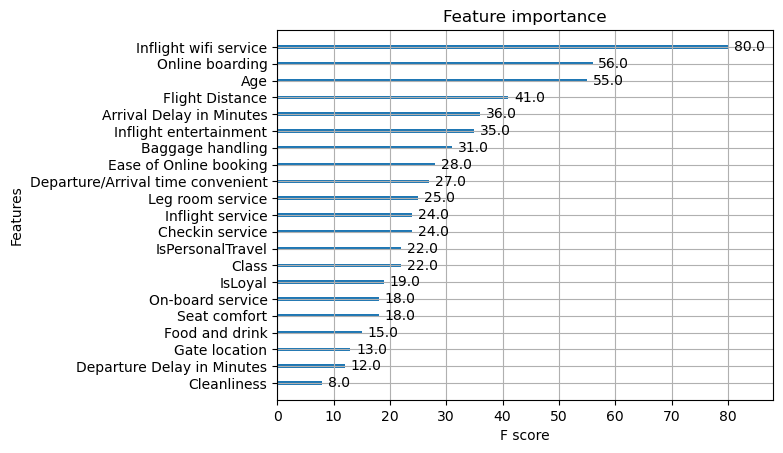

In [24]:
# Plot the relative feature importance of the predictor variables in your model.
plot_importance(xgb_cv.best_estimator_)

<details>
<summary><h4><strong>Hint 1</strong></h4></summary>

Recall the attributes that are provided once the model is fitted to training data.</details>

<details>
<summary><h4><strong>Hint 2</strong></h4></summary>

Examine the `best_estimator_` attribute of your fitted model.</details>

<details>
<summary><h4><strong>Hint 3</strong></h4></summary>

To easily visualize feature importance, call the built-in `plot_importance` function `xgboost` offers on the `best_estimator_`.</details>

**Question:** Examine the feature importances outputted above. What is your assessment of the result? Did anything surprise you?

- Wifi service seems to be a really big factor which is surprising.
- Flight Delay didn't score as high as it should.

### Compare models

Create a table of results to compare model performance.

In [25]:
# Create table of results.
table = pd.DataFrame({'Model': "Tuned Decision Tree",
                        'F1':  0.948,
                        'Recall': 0.934,
                        'Precision': 0.934,
                        'Accuracy': 0.955
                      }, index= [0]
                    )
table.loc[len(table.index)] = ['Tuned Random Forest', 0.951, 0.940, 0.962, 0.958]

table.loc[len(table.index)] = ["Tuned XGBoost Model", round(f1_score(y_test, y_pred), 3),
                                round(recall_score(y_test, y_pred), 3), round(precision_score(y_test, y_pred), 3),
                                round(accuracy_score(y_test, y_pred), 3)]

table

,Model,F1,Recall,Precision,Accuracy
0,Tuned Decision Tree,0.948,0.934,0.934,0.955
1,Tuned Random Forest,0.951,0.940,0.962,0.958
2,Tuned XGBoost Model,0.943,0.929,0.958,0.951


<details>
<summary><h4><strong>Hint 1</strong></h4></summary>

Create a DataFrame and use the `append()` function to add the results of each model as a new row.

</details>

**Question:** How does this model compare to the decision tree and random forest models you built in previous labs? 

Based on the results shown in the table above, the F1, precision, recall, and accuracy scores of the XGBoost model are similar to the corresponding scores of the decision tree and random forest models. The random forest model seemed to outperform the decision tree model as well as the XGBoost model.

## Considerations

**What are some key takeaways you learned from this lab?**

1. The evaluation of the model is important to inform if the model has delivered accurate predictions.
2. Splitting the data is important for ensuring that there is new data for the model to test its predictive performance.
3. Each metric provides an evaluation from a different standpoint, and accuracy alone is not a strong way to evaluate a model.
4. Effective assessments balance the true/false positives versus true/false negatives through the confusion matrix and F1 score.

**How would you share your findings with your team?**

1. Showcase the data used to create the prediction and the performance of the model overall.
2. Review the sample output of the features and the confusion matrix to reference the model's performance.
3. Highlight the metric values, emphasizing the F1 score.
4. Visualize the feature importance to showcase what drove the model's predictions.

**What would you share with and recommend to stakeholders?**

1. The model created is highly effective at predicting passenger satisfaction.
2. The feature importance of inflight wifi service warrants additional investigation. It will be important to ask domain experts why they believe this feature scores so highly in this model.